Урок 5. Оцениваем точность моделей с помощью разнообразных метрик\
Используя набор данных о домах, примените метрики для оценки качества модели регрессии.\
Затем, используя набор данных об ирисах, примените метрики для оценки качества модели классификации.\

Шаги для выполнения задания:\

1. Загрузите набор данных о домах и набор данных об ирисах.\
2. Разделите данные на обучающую и тестовую выборки.\
3. Создайте модель регрессии и обучите ее на обучающей выборке.\
4. Примените метрики для оценки качества модели регрессии на тестовой выборке.\
5. Создайте модель классификации и обучите ее на обучающей выборке.\
6. Примените метрики для оценки качества модели классификации на тестовой выборке.\

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import io
from pathlib import Path


In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()

In [4]:
# сформируем датайрейм из данных
# дадим признакам более короткие (удобные) наименования
# добавим к датасетсу целевую переменную
df = pd.DataFrame(data.data, columns=data.feature_names)
df.rename(columns={'sepal length (cm)':'sepal_l',
                    'sepal width (cm)':'sepal_w',
                    'petal length (cm)':'petal_l',
                    'petal width (cm)':'petal_w'}, inplace=True)
df['target'] = data.target
# Оставим только два класса
df = df.loc[df.target.isin([0, 1])]
df.head(3)

,sepal_l,sepal_w,petal_l,petal_w,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


In [5]:
dataset_filename = 'iris'
info_filename = f'./{Path(dataset_filename).stem}_info.xlsx'
buf = io.StringIO()
df.info(buf=buf)
s = buf.getvalue()
columns = s.splitlines()[3].split()
lines =   [line.split() for line in s.splitlines()[5:-2]]
lines = [[' '.join(row[1:-3]), row[-3], row[-2], row[-1]   ] for row in lines]
df_info = pd.merge(
    pd.DataFrame(lines, columns=columns[1:])
    , df.nunique().to_frame(name='Nu'), 
    left_on='Column', 
    right_index=True)# .set_index(['#']).reset_index()
df_vc = pd.DataFrame([[col, sorted(df[col].value_counts().to_dict().items(), key=lambda x: x[0])] for col in df.columns if len(df[col].value_counts()) < 21], columns=['Column', 'vc'])
df_info = pd.merge(df_info, df_vc, how='left', on='Column')
df_info = pd.merge(df_info, df.describe().T, how='left', left_on='Column', right_index=True)
df_info = df_info[['Column', 'Non-Null']].copy()\
    .join(pd.DataFrame(df.isna().sum()).rename(columns={0: 'Null_cnt'}), how='left', on='Column')\
    .join(pd.DataFrame(df.isna().sum() / df.shape[0]).round(3).rename(columns={0: 'Null_percent'}), how='left', on='Column')\
    .join(df_info.set_index('Column').drop(columns=['Non-Null', 'Count'] ), how='left', on='Column')
if not Path(info_filename).exists():
    df_info.to_excel(info_filename, index=False)
df_info

,Column,Non-Null,Null_cnt,Null_percent,Dtype,Nu,vc,count,mean,std,min,25%,50%,75%,max
0,sepal_l,100,0,0.0,float64,28,NaN,100.0,5.471,0.641698,4.3,5.0,5.40,5.900,7.0
1,sepal_w,100,0,0.0,float64,23,NaN,100.0,3.099,0.478739,2.0,2.8,3.05,3.400,4.4
2,petal_l,100,0,0.0,float64,28,NaN,100.0,2.861,1.449549,1.0,1.5,2.45,4.325,5.1
3,petal_w,100,0,0.0,float64,15,"[(0.1, 5), (0.2, 29), (0.3, 7), (0.4, 7), (0.5...",100.0,0.786,0.565153,0.1,0.2,0.80,1.300,1.8
4,target,100,0,0.0,int32,2,"[(0, 50), (1, 50)]",100.0,0.500,0.502519,0.0,0.0,0.50,1.000,1.0


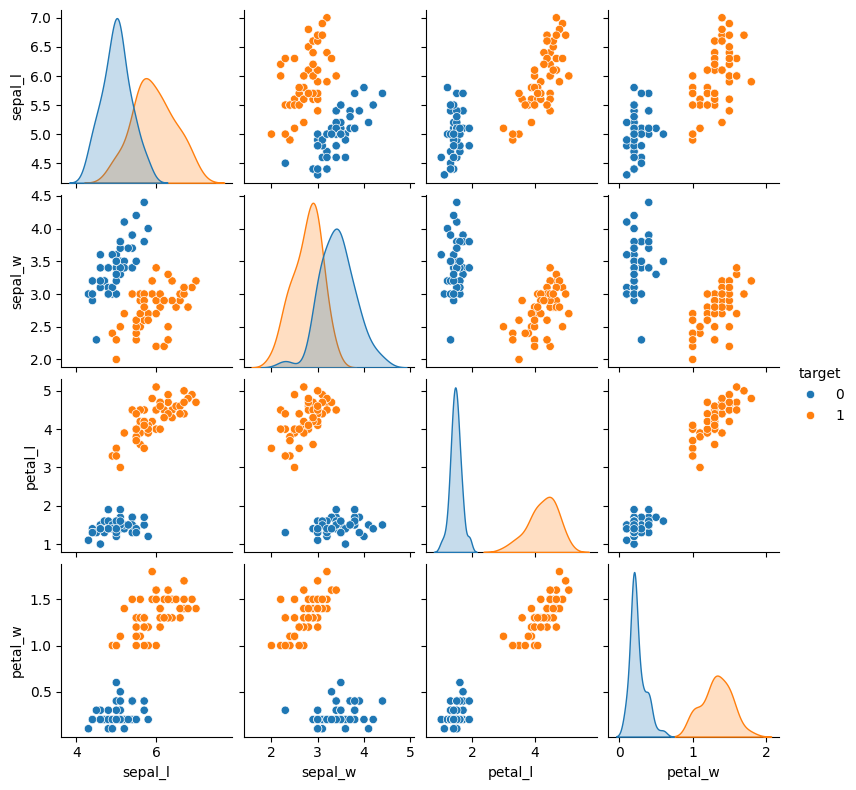

In [6]:
# Выведем парную диаграмму
sns.pairplot(df, hue='target', height=2);
# Видим, что классы достаточно хорошо линейно разделимы

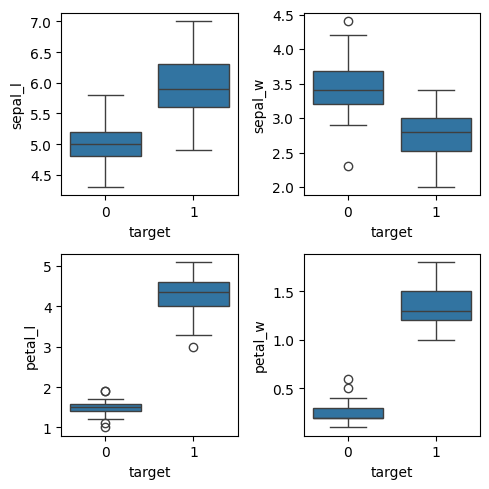

In [7]:
def graph(y): 
    sns.boxplot(x="target", y=y, data=df) 
  
plt.figure(figsize=(5,5)) 
      
plt.subplot(221) 
graph('sepal_l') 
  
plt.subplot(222) 
graph('sepal_w') 
  
plt.subplot(223) 
graph('petal_l') 
  
plt.subplot(224) 
graph('petal_w') 
plt.tight_layout();  
plt.show();

# Как видно из графиков, хорошей разделяющей способностью по целевой переменной должны обладать признаки petal_*.
# Учитывая, что они сильно между собой скоррелированы. Возможно получить ограничиться только одним из них.

In [8]:
# Признаки имеют разный масштаб. Целесообразно стандартизовать признаки.
# При разбиении датасета постараемся не сместить баланс классов целевой переменной
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape, X_test_scaled.shape)

(80, 4) (20, 4) (80,) (20,)
(80, 4) (20, 4)


In [9]:
model = LogisticRegression()

In [10]:
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [13]:
y_test_pred= model.predict(X_test_scaled)

In [15]:
print(accuracy_score(y_test, y_test_pred))
print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred))
print(roc_auc_score(y_test, y_test_pred))
# Получили отличные метрики на тестовой выборке при базовых параметрах модели - причина в том, что судя по построенным диаграммамм, классы хорошо линейно разделимы.

1.0
1.0
1.0
1.0
1.0


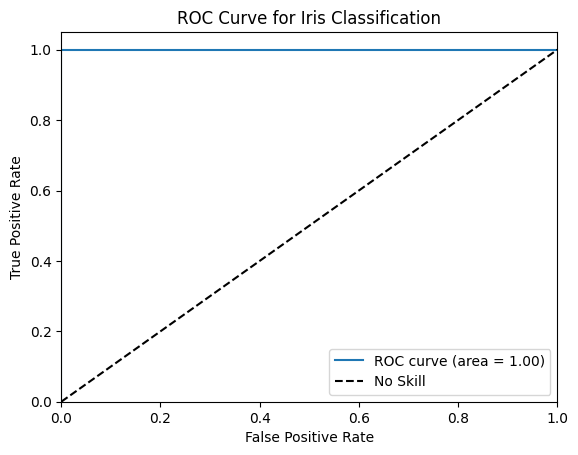

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Iris Classification')
plt.legend()
plt.show()

# Как мы видим график представляет собой линию y=1